In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import display, HTML, IFrame, Image, Video
# display(HTML("<style>.container {width:78% !important;}</style>"))

In [3]:
from datetime import date
import math
import glob
import os

import numpy as np
import plotly.graph_objects as go
import plotly.offline as pl
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from PIL import ImageOps, Image as PIL_Image

# Skyrmion breathing using the domain wall ansatz

This notebook contains 5 sections:

1. A short introduction describing the equations investigated.
2. Creating an example magnetic skyrmion visualization using Plotly.
3. Discussion of how the energy landscape surface figure leads to two kinds of solutions available  (*rotational* versus *oscillatory* breathing skyrmions)
4. Numerically solving the equations to create animations.  
    4a. Using numerically calculated data to create animation for rotational breathing.  
    4b. Using numerically calculated data to create animation for oscillatory breathing.
5. Line plots for an example figure from our manuscript

## 1: Introduction

[Our paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.054430) described the nonlinear breathing-like behavior of large radius skyrmions in chiral ferromagnets.  
Expanding on the results of the paper for a specific example, in this notebook I will consider a skyrmion in a chiral ferromagnetic thin film in the large radius limit.  
For this we use the 360 degree domain wall (DW) ansatz for the magnetization:

\begin{equation}
\boldsymbol{m} = 
    \begin{pmatrix} 
    m_{x} \\
    m_{y} \\
    m_{z} 
    \end{pmatrix} 
    = 
    \begin{pmatrix}
       \cos(\psi+\eta) \operatorname{sech} \left( \frac{\rho-R}{\Delta} \right) \\
       \sin(\psi+\eta) \operatorname{sech} \left( \frac{\rho-R}{\Delta} \right) \\
       \tanh \left(  \frac{\rho-R}{\Delta} \right)
    \end{pmatrix} \label{eq:m}
\end{equation}

where $\rho>0$ and $\psi \in [0,2\pi)$ are the plane polar coordinates $(x,y) = (\rho\cos\psi,\rho\sin\psi)$, and by "large radius limit" we specifically mean $R \gg \Delta$.

By using Eq.(1), along with the energy functional describing the micromagnetic properties of the thin film material and the Landau-Lifshitz-Gilbert equation, I have derived a dimensionless function describing the skyrmion's energy $\varepsilon$ in terms of the dimensionless skyrmion radius $r$ and skyrmion phase $\eta$,

\begin{align}
\varepsilon = \left( \frac{1}{|g|} +|g| -2g \cos\eta \right)r +  \frac{|g|}{r}
\end{align}

and the effective dynamical system for the time evolution of $r$ and $\eta$

\begin{align}
\dot{r}
&= -\frac{1}{1+\alpha^{2}}\left( 2g\sin\eta + \alpha |g|\frac{\varepsilon r-2|g|}{r^{3}}  \right) \\
\dot{\eta}
&= \frac{1}{1+\alpha^{2}}\left(\frac{\varepsilon r-2|g|}{r^{3}} - 2\alpha g|g|^{-1} \sin\eta  \right)
\end{align}

In equations (2)-(4) above, the dimensionless skyrmion radius $r$ is measured in units of the DW width $\Delta$ (i.e., $r = R/ \Delta$), overdots denote time derivatives, and time is also measured in dimensionless units of $M_{s}/(\gamma K)$. There are also two dimensionless parameters in this system of equations: the phenomenological Gilbert damping constant $\alpha$, and a further material parameter $g$.

In terms of material parameters available experimentally, we have $\Delta = \sqrt{A/K}$, $g = \pi D / (4\sqrt{AK})$, where

* $A$ is the exchange energy constant.
* $D$ is the Dyaloshinsky-Moriya energy constant.
* $M_{s}$ is the saturation magnetization constant.
* $K$ is the perpendicular magnetic anisotropy energy constant.
* $\gamma$ is the gyromagnetic ratio constant from the Landau Lifshitz Gilbert equation.

**Important**: if the damping constant is set to zero, $\alpha =0$, then energy is a time-independent constant fixed by the initial conditions of $r$ and $\eta$ at time $t=0$. When $\alpha \neq 0$, the energy monotonically decreases over time: $\dot{\varepsilon} <0$

## 2: Example magnetic skyrmion visualization using Plotly

Below we use Plotly to create a visualization of a magnetic skyrmion using the 360 degree domain wall ansatz in Eq. (1).

In [4]:
R = 10     # radius
eta = 0    # skyrmion phase
Delta = 2  # skyrmion's domain wall width

def calc_conefield2D(x,y, Delta=2):
    """Returns a Plotly Cone object at a point in the (x,y) plane"""

    # plane polar coordinates
    psi = np.arctan2(y,x)
    rho = np.sqrt(x**2 + y**2)
    
    # 360 degree domain wall ansatz for an axisymmetric skyrmion
    # (See Eq. (1) at the top of this notebook)
    # np.around used because plotly.js doesn't like full precision float64s
    
    mx = np.around(np.cos(eta+psi)/np.cosh((rho-R)/Delta),decimals=5)
    my = np.around(np.sin(eta+psi)/np.cosh((rho-R)/Delta),decimals=5)
    mz = np.around(np.tanh((rho - R)/Delta),decimals=5)
    
    return go.Cone(x=[x],y=[y],z=[0],
                   u=[mx],v=[my],w=[mz],
                   anchor='cm',
                   sizemode='scaled',
                   sizeref=1.5,
                   showscale=False)


# Creating the Plotly figure

conedata = [calc_conefield2D(x,y) for x in np.arange(-25,25,3) for y in np.arange(-25,25,3)]

layout = go.Layout(
    width=800,
    height=600,
    autosize=False,
    scene=dict(
        camera=dict(eye=dict(x=0.55,y=0.90,z=0.90)), # adjust norm of `eye` to zoom
        xaxis=dict(range=[-25,25],showbackground=False,visible=False),
        yaxis=dict(range=[-25,25],showbackground=False,visible=False),
        zaxis=dict(range=[-25,10],showbackground=False,visible=False)
    )
)

fig = go.Figure(data=conedata, layout=layout)
fig.update_layout(
    title='<b>Interactive magnetic skyrmion visualisation made with Plotly</b>',
    title_x=0.5
)

#pl.plot(fig,filename='skyrmion.html',auto_open=False)
fig.show()

## 3: Three dimensional surface plot for the energy landscape

I made the next two figures below for our [publication](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.054430) using Mathematica and Inkscape. It illustrates the different kinds of breathing found for a magnetic skyrmion.

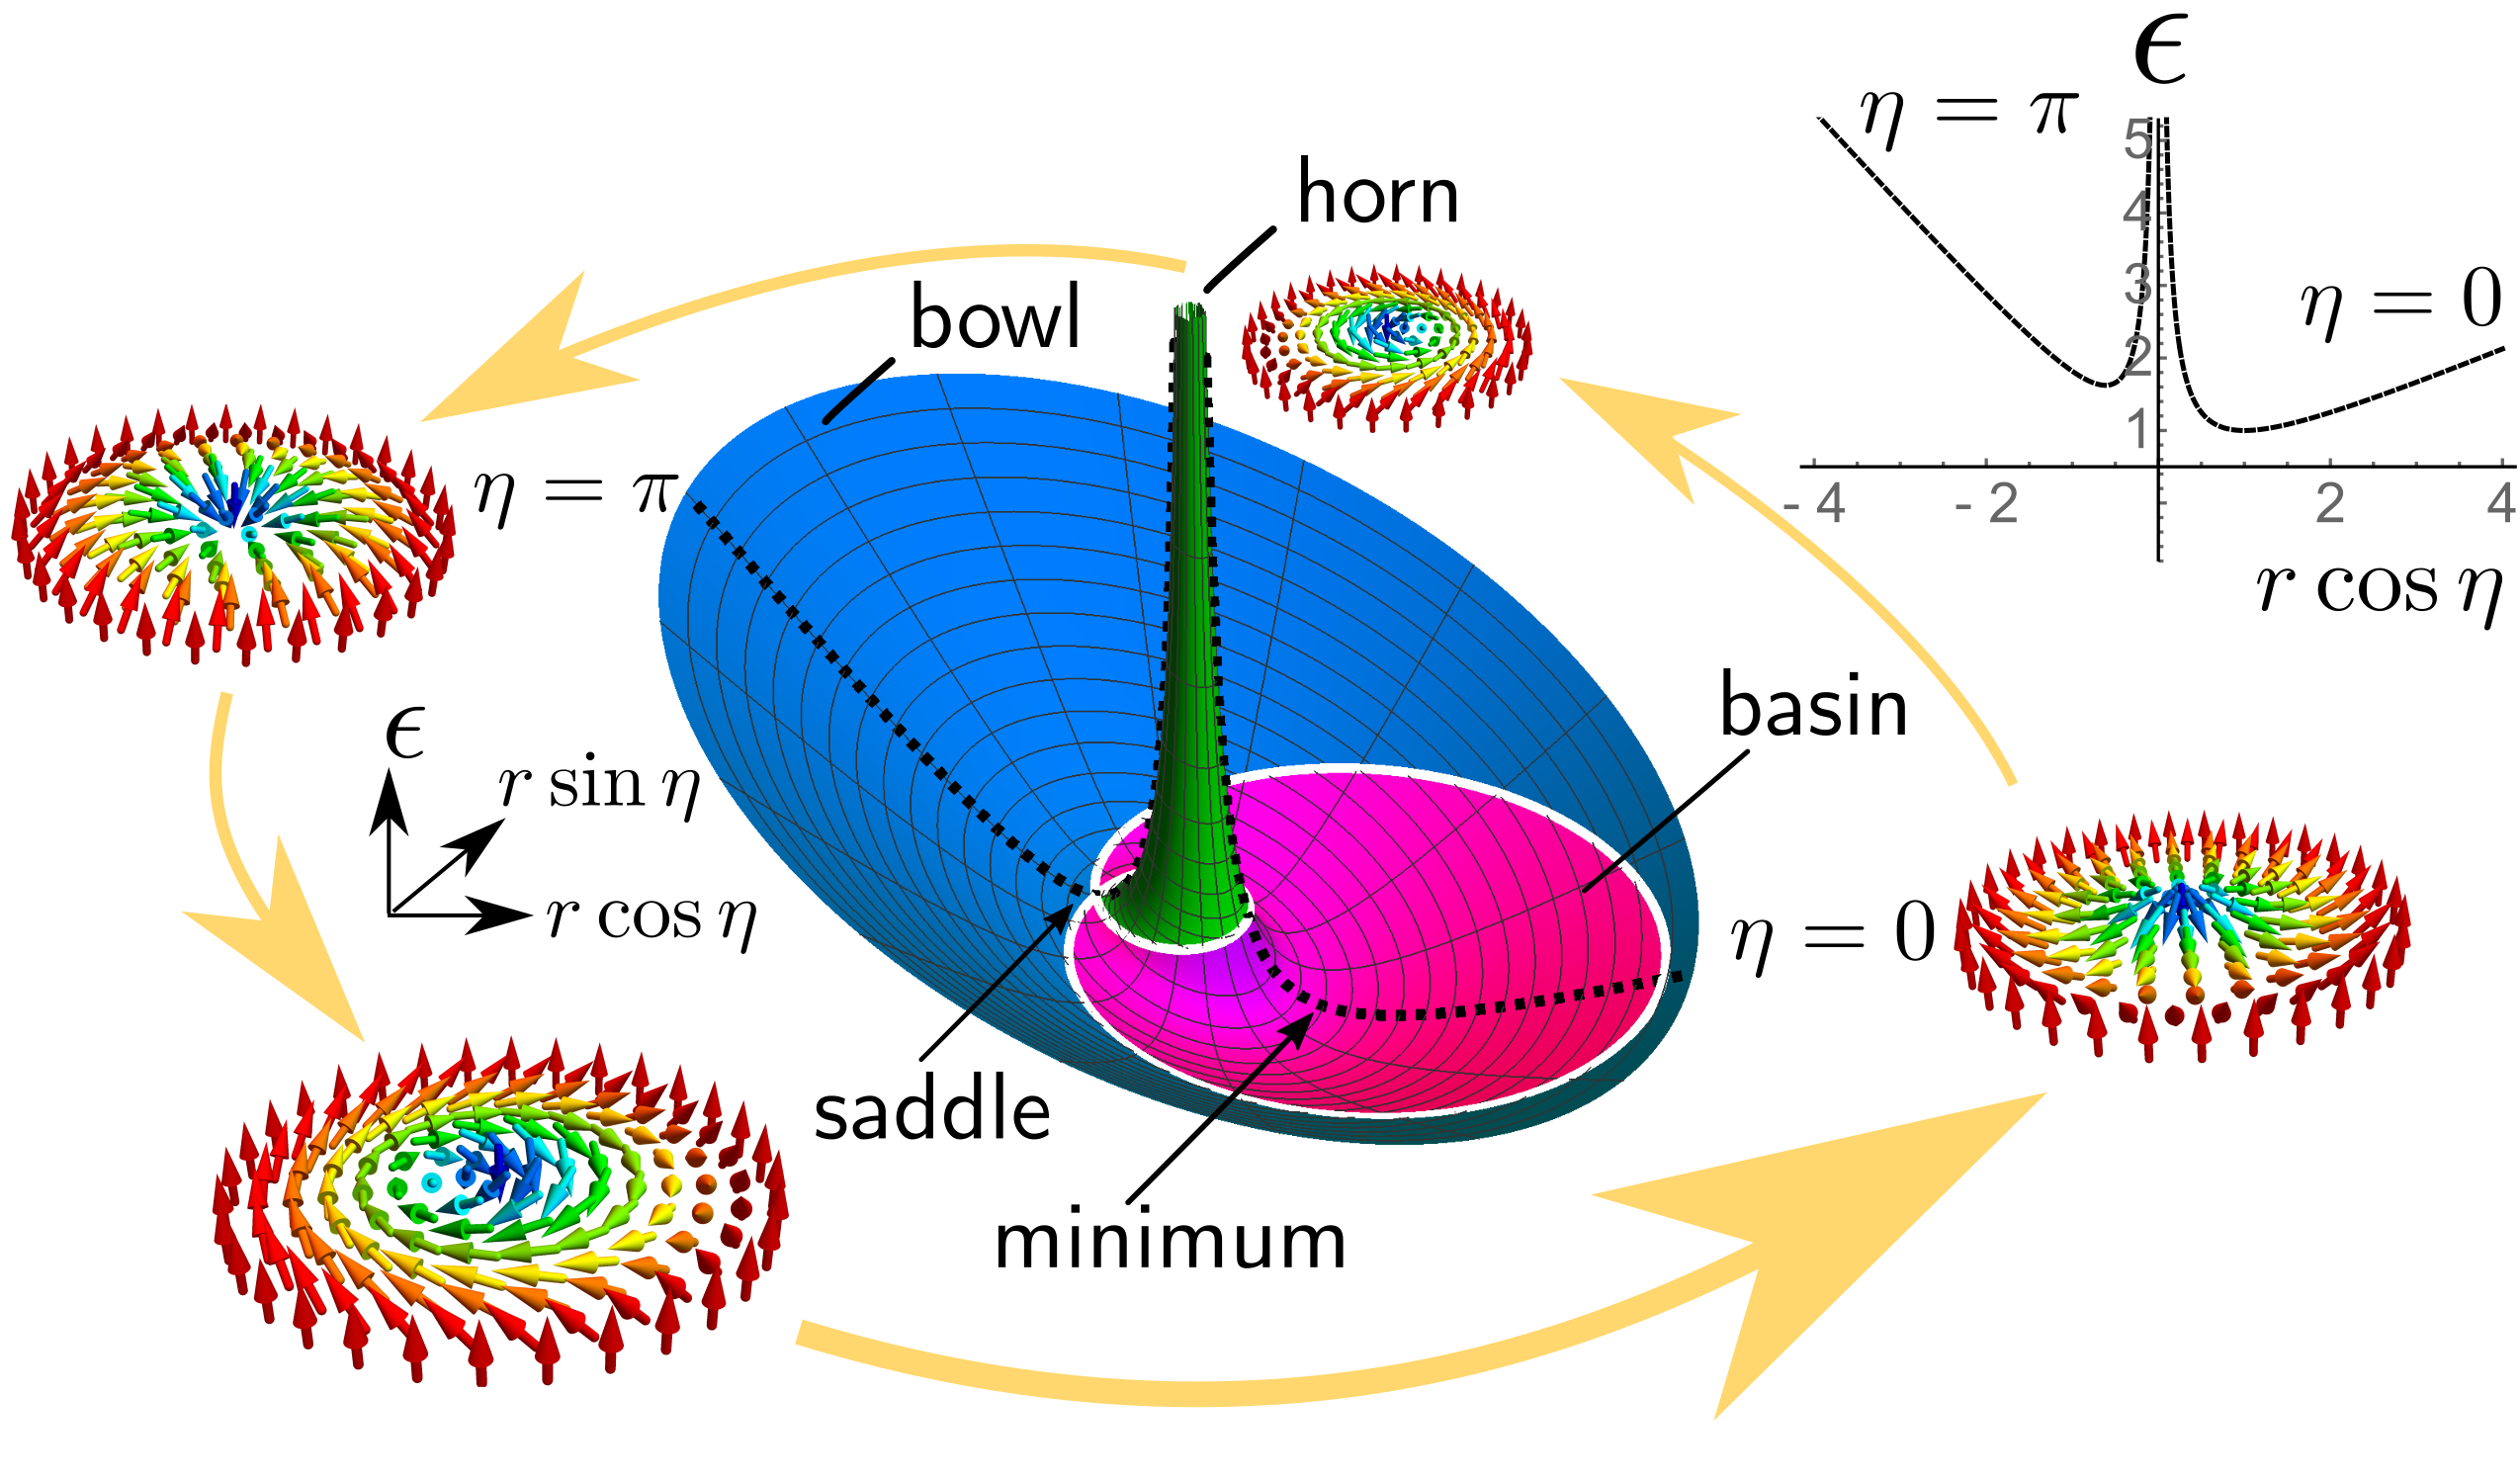

In [5]:
Image('energy-landscape.png',width=700)

* When the skyrmion's energy is high, in the blue (bowl) region, the skyrmions radius grows and shrinks while the spins continuously rotate in one direction. **See blue constant energy orbit in figure (a) below.**

* When the energy is lower, in the pink (basin) region, the skyrmion can no longer fully rotate as it breathes; instead the phase $\eta$ oscillates around its equilibrium value near the minimum point. **See pink constant energy orbit line in figure (a) below.**

* The second rotation solution (**see green constant energy orbit in figure (a) below**) is on the horn of the energy landscape -- the green region above. This solution is an unphysical artefact of the model because it suggests the skyrmion energy diverges as its radius approaches zero. This can be safely ignored because a key assumption in the derivation of equations (2)-(4) is that we are working in the *large* radius limit, which means that the equations are no longer applicable as the radius approaches zero. 

Note that the origin $r=0$ lies directly below the horn.

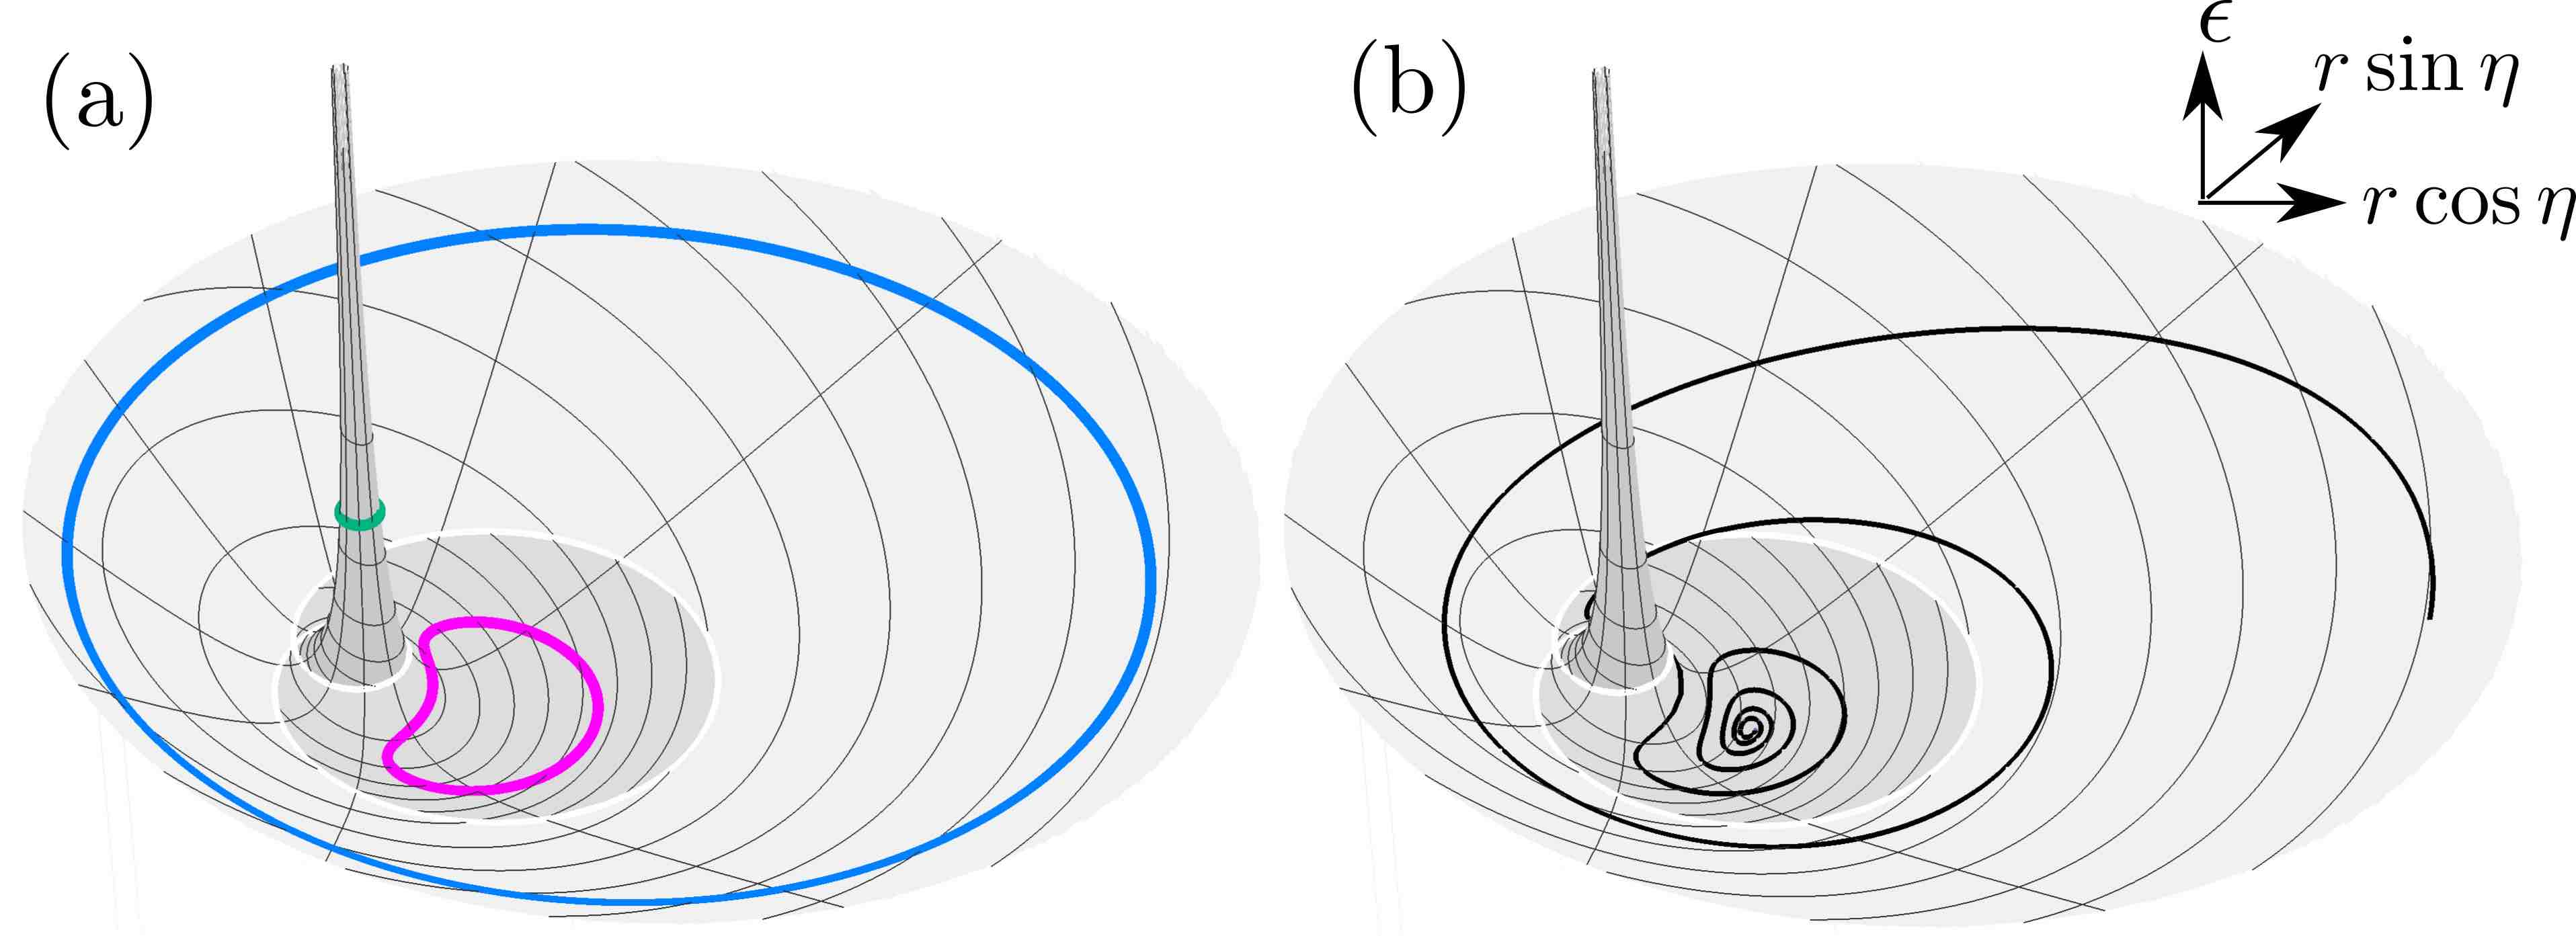

In [6]:
Image('fig-3-example-orbits.jpg',width=700)

* The undamped solutions illustrated in figure (a) above are easily analytically obtained by inverting Eq. (2) for $r$.
* The damped solution in figure (b) above shows what happens as the skyrmion transitions from rotational breathing to oscillatory breathing which happens when the energy drops below the saddle point -- eventually the ($r$,$\eta$) coordinates spiral towards equilibrium at the minimum of the energy landscape at the bottom of the basin.


The damped solution in (b) was solved numerically in Python and the data was then imported into Mathematica to overlay on top of the surface plot. 
Details on the numerical integration in python for Eqs.(2)-(4) are shown in the next section.

## 4: Numerically solving the system of equations

Below we define some functions for numerically solving the system of Equations (2)-(4).

In [7]:
def Nrg(z,g):
    """
    Energy function for a skyrmion. See Eq.(2)
    
    Parameters
    ==========
    
    z: array 
       contains [dimensionless skyrmion radius, skyrmion phase]
    g: float
       material parameter \pi D / (4\sqrt{AK})
       
    Returns
    =======
    
    E: float
       Energy
    """
    
    E = (np.abs(g)/z[0])*((1+g**2-2*g*np.abs(g)*math.cos(z[1]))*((z[0]**2)/g**2)+1)
    return E

def F_dyn(z,a,g): 
    """ 
    Returns the right side of the dynamical system
    of equations for a breathing skyrmion according 
    to the 360 degree domain wall ansatz.
    
    See Eqs. (3) and (4)
    
    Parameters
    ==========
    
    z: array 
       contains [dimensionless skyrmion radius, skyrmion phase]
    a: float
       Gilbert damping parameter alpha
    g: float
       material parameter \pi D / (4\sqrt{AK})
    """

    p = 1/(1+a**2)
    q0 = (z[0]*Nrg(z,g)-2*np.abs(g))/(z[0]**3)
    q1 = 2*g*math.sin(z[1])
    q2 = np.abs(g)*q0
    q3 = q1 / np.abs(g)

    tempv = np.zeros(2)
    tempv[0] = -p*(q1 + a*q2)    # \dot{r}
    tempv[1] = p*(q0 - a*q3)     # \dot{\eta}
    return tempv


def NDSolve(step_size,steps,z0,a,g):
    """
    Implementation of the Runge Kutta 4 algorithm for solving 
    the nonlinear N=2 dynamical system.
    
    Parameters
    ==========
    
    step_size: float
    steps: int
    z0: array
       contains initial conditions for 
       [dimensionless skyrmion radius, skyrmion phase]
    a: float
       Gilbert damping parameter
    g: float
       material parameter \pi D / (4\sqrt{AK})
       
    Returns
    =======
    
    Returns a tuple with three components:
    
        x: list
           first sublist is the radius signal
           second sublist is the skyrmion phase signal
           i.e.
           [[r0,r1,r2,...], [eta0,eta1,eta2,...]]

        E: list
           Energy 
           [E0,E1,E2,...]

        i+1: int
             total number of time steps
    """
    
    step = step_size
    n_step = steps

    x = np.zeros([2,steps+1])
    x[:,0] = z0 # initial position

    E = np.zeros(steps+1)
    E[0] = Nrg(x[:,0],g)

    for i in range(0,n_step): #RK-4

        k_1 = step*F_dyn(x[:,i],a,g)
        k_2 = step*F_dyn(x[:,i]+(k_1/2.),a,g)
        k_3 = step*F_dyn(x[:,i]+(k_2/2.),a,g)
        k_4 = step*F_dyn(x[:,i]+k_3,a,g)

        x[:,i+1] = x[:,i]+(1./6.)*(k_1+2.*k_2+2.*k_3+ k_4)
        E[i+1] = Nrg(x[:,i+1],g)
        
    return (x, E, i+1)

### 4a: Creating an animation for rotational breathing

By using the functions defined above, we can solve Eqs.(3)-(4) for some reasonable initial conditions, and then make further visualizations of skyrmions like in Section 2 of this notebook by using the numerically obtained data. I will combine different images together to create an animation of rotational breathing.

Choosing appropriate initial conditions to get nice data requires a bit of trial and error:

* The step size for the solver has to be small enough to ensure stability of the numerical algorithm.
* If the step size is *too* small then we will make too many images to reasonably animate.
* To ensure we are in the right regime for rotations (on the bowl of the energy landscape), I will fix the initial $\eta$ to be $\eta(\tau=0)=0$, and then the radius simply has to be larger than the radius at the saddle point energy.

In [8]:
def calc_field_components(x,y,R,eta, Delta=2):
    """ 
    Returns field components for the 360 degree domain wall ansatz
    describing skyrmions in the large radius limit.
    
    See Eq. (1) at the top of the notebook.
    
    Parameters
    ==========
    
    x: integer, x coordinate of the spin
    y: integer, y coordinate of the spin
    R: float, location of the domain wall center (i.e. the contour where mz = 0)
    eta: float, skyrmion phase
    Delta: float (optional), domain wall width
    
           I will rescale r=R/\Delta later for a convenient visualization. 
           Strictly speaking Delta = |g| should be used for consistency 
           with Eqs (2)-(4) and then Delta should be rescaled similarly.
    
    """
    
    psi = np.arctan2(y,x)
    rho = np.sqrt(x**2 + y**2)
    
    mx = np.cos(eta+psi)/np.cosh((rho-R)/Delta)
    my = np.sin(eta+psi)/np.cosh((rho-R)/Delta)
    mz = np.tanh((rho - R)/Delta)
    
    return mx,my,mz

Parameters for the differential equation solver `NDSolve`:

In [9]:
g = 0.6             # material constant
steps = 126
step_size = 1.6e-1
a = 0.0             # Gilbert damping constant

Initial conditions for the solver:

In [10]:
# equilibrium radius formula
req = np.abs(g) / np.sqrt(1-g**2) 

# initial conditions (above the saddle energy)
r0 = 6*req            
eta0 = 0.0
z0 = [r0, eta0]     

#### Solving the system of equations:

In [11]:
init_energy = Nrg(z0,g)
t = np.linspace(0,step_size*steps,steps+1)
z, Energy, fstep = NDSolve(step_size,steps,z0,a,g)
print('total time = ', step_size*steps)
print('total steps = ', steps)

total time =  20.16
total steps =  126


#### Quick check

We can quickly check the results by comparing to an analytical formula derived for trajectories on the energy landscape:

\begin{align}
r_{\pm}(\varepsilon,\cos\eta) = \frac{\sqrt{\varepsilon^{2}-4(a+b\cos\eta)c}}{2(a+b\cos\eta)}
\end{align}

Amplitude on the bowl ($g>0$)

\begin{align}
 r_{+}(\epsilon,1) - r_{+}(\epsilon,-1) = \frac{\sqrt{\varepsilon^{2}-4(a+b)c}}{2(a+b)} - \frac{\sqrt{\varepsilon^{2}-4(a-b)c}}{2(a-b)}
\end{align}

where $a = |g|^{-1} + |g|$, $b = -2g$, and $c = |g|$.

In [12]:
def bowl_amp(eps,g):
    "Formula for the amplitude of bowl trajectories"
    
    a = (1/np.abs(g)) + np.abs(g)
    b = -2*g
    c = np.abs(g)

    left = (eps + np.sqrt(eps**2 - 4*(a+b)*c))/ (2*(a+b))
    right = (eps + np.sqrt(eps**2 - 4*(a-b)*c)) / (2*(a-b))
    
    return left - right

print('amplitude from formula = ', bowl_amp(init_energy,g))
print('amplitude from NDSolve = ',np.max(z[0]) - np.min(z[0]))

amplitude from formula =  3.21121803769986
amplitude from NDSolve =  3.2111259529784597


Looks good.

#### Investigating the results with some line plots

In [13]:
# Setting up figure parameters in matplotlib
matplotlib.rc('text',usetex = True)
matplotlib.rcParams['figure.figsize'] = [9.0,7.0]
matplotlib.rcParams['lines.linewidth'] = 2
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

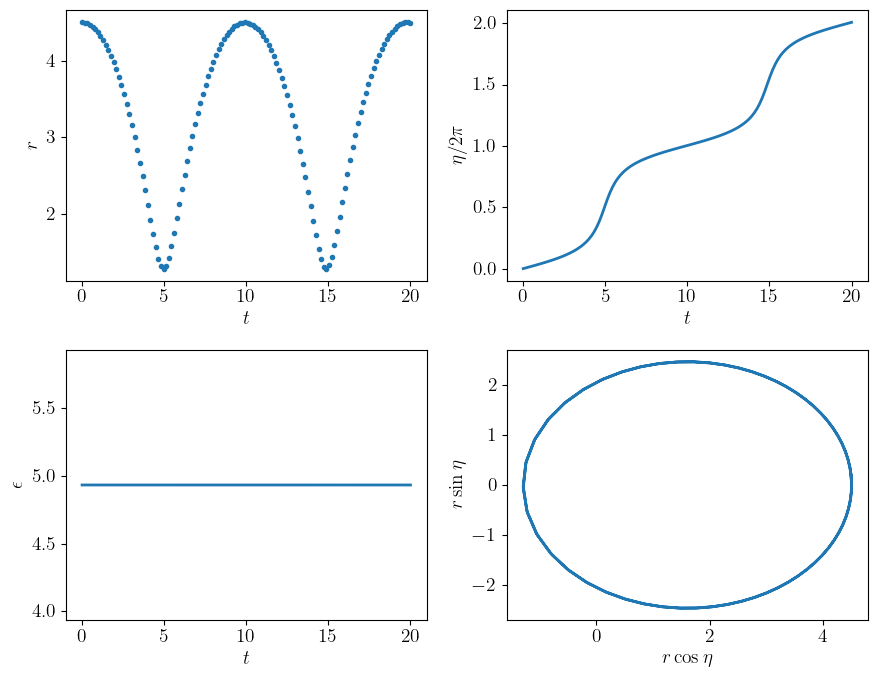

In [14]:
# plot the results
fig, axs = plt.subplots(2,2)
axs[0,0].plot(t[:fstep],z[0,:fstep],'.') # plot individual points for radius signal
axs[0,0].set_xlabel(r'$t$')
axs[0,0].set_ylabel(r'$r$')
axs[0,1].plot(t[:fstep],z[1,:fstep]/(2*math.pi)) # phase signal in unit of 2\pi
axs[0,1].set_xlabel(r'$t$')
axs[0,1].set_ylabel(r'$\eta/2\pi$')
axs[1,0].plot(t[:fstep],Energy[:fstep]) # energy signal
axs[1,0].set_ylim([np.max(Energy)-1,np.max(Energy)+1])
axs[1,0].set_xlabel(r'$t$')
axs[1,0].set_ylabel(r'$\epsilon$')
axs[1,1].plot(z[0,:fstep]*np.cos(z[1,:fstep]),z[0,:fstep]*np.sin(z[1,:fstep])) # energy orbit on bowl
axs[1,1].set_xlabel(r'$r\cos\eta$')
axs[1,1].set_ylabel(r'$r\sin\eta$')
fig.tight_layout();

#### Processing the data using Pandas to prepare for the Plotly visualization

In [15]:
rots = pd.DataFrame(z.T,columns=['r','eta'])

In [16]:
rots['four_times_r'] = 4*rots['r'] # artificially rescale the radius signal for visualization purposes

print('dataframe head: \n')
print(rots.head())
print('\n')
print('min r: ', rots['four_times_r'].min())
print('max r: ', rots['four_times_r'].max())

dataframe head: 

          r       eta  four_times_r
0  4.500000  0.000000     18.000000
1  4.496460  0.036891     17.985839
2  4.485833  0.073896     17.943332
3  4.468102  0.111128     17.872407
4  4.443236  0.148707     17.772942


min r:  5.155496188086158
max r:  17.999999999999996


Building a pandas dataframe for magnetization components in the $(x,y)$ plane:

In [17]:
def generate_df(R,eta):
    """ 
    Returns a pd.DataFrame describing a skyrmion with profile 
    described by the domain wall ansatz given a radius and skyrmion phase
    
    (Note Delta=2 is fixed inside calc_field_components)
    
    The resulting DataFrame describes 289 spins in a 17 * 17 grid
    across the (x,y) plane from -25 to +25 in both directions.
    """


    dd = dict(x=np.array([]),
              y=np.array([]),
              z=np.array([]),
              u=np.array([]),
              v=np.array([]),
              w=np.array([]))

    for x in np.arange(-25,25,3):
        for y in np.arange(-25,25,3):

            mx,my,mz = calc_field_components(x,y,R,eta)

            dd['x'] = np.around(np.append(dd['x'],x) ,decimals=3)
            dd['y'] = np.around(np.append(dd['y'],y) ,decimals=3)
            dd['z'] = np.around(np.append(dd['z'],0) ,decimals=3)
            dd['u'] = np.around(np.append(dd['u'],mx),decimals=3)
            dd['v'] = np.around(np.append(dd['v'],my),decimals=3)
            dd['w'] = np.around(np.append(dd['w'],mz),decimals=3)
    
    return pd.DataFrame(dd)

In [18]:
rvals = rots['four_times_r'].values
evals = rots['eta'].values

In [19]:
len(evals)

127

In [20]:
print(evals[123:]/(2*np.pi))  # 2 oscillations occur just before 124 time steps

[1.99520461 2.00107467 2.00694801 2.01284268]


In [21]:
# Concatenating magnetization data at different times into one DataFrame
df = pd.concat([generate_df(r,e) for r,e in zip(rvals,evals)],keys=range(len(rvals)),axis=1)

df.index = df.index.set_names('spins')
df.columns = df.columns.set_names('times',level=0)

df

times   0                                     1                      ...  125  \
          x     y    z      u      v      w     x     y    z      u  ...    z   
spins                                                                ...        
0     -25.0 -25.0  0.0 -0.000 -0.000  1.000 -25.0 -25.0  0.0 -0.000  ...  0.0   
1     -25.0 -22.0  0.0 -0.001 -0.001  1.000 -25.0 -22.0  0.0 -0.001  ...  0.0   
2     -25.0 -19.0  0.0 -0.002 -0.001  1.000 -25.0 -19.0  0.0 -0.002  ...  0.0   
3     -25.0 -16.0  0.0 -0.005 -0.003  1.000 -25.0 -16.0  0.0 -0.005  ...  0.0   
4     -25.0 -13.0  0.0 -0.011 -0.006  1.000 -25.0 -13.0  0.0 -0.011  ...  0.0   
...     ...   ...  ...    ...    ...    ...   ...   ...  ...    ...  ...  ...   
284    23.0  11.0  0.0  0.043  0.020  0.999  23.0  11.0  0.0  0.041  ...  0.0   
285    23.0  14.0  0.0  0.020  0.012  1.000  23.0  14.0  0.0  0.019  ...  0.0   
286    23.0  17.0  0.0  0.008  0.006  1.000  23.0  17.0  0.0  0.008  ...  0.0   
287    23.0  20.0  0.0  0.003  0.003  1.000  23.0  20.0  0.0  0.003  ...  0.0   
288    23.0  23.0  0.0  0.001  0.001  1.000  23.0  23.0  0.0  0.001  ...  0.0   

times                        126                                  
           u      v      w     x     y    z      u      v      w  
spins                                                             
0     -0.000 -0.000  1.000 -25.0 -25.0  0.0 -0.000 -0.000  1.000  
1     -0.001 -0.001  1.000 -25.0 -22.0  0.0 -0.001 -0.001  1.000  
2     -0.002 -0.002  1.000 -25.0 -19.0  0.0 -0.002 -0.002  1.000  
3     -0.005 -0.003  1.000 -25.0 -16.0  0.0 -0.004 -0.003  1.000  
4     -0.011 -0.006  1.000 -25.0 -13.0  0.0 -0.010 -0.006  1.000  
...      ...    ...    ...   ...   ...  ...    ...    ...    ...  
284    0.041  0.022  0.999  23.0  11.0  0.0  0.039  0.023  0.999  
285    0.019  0.013  1.000  23.0  14.0  0.0  0.018  0.013  1.000  
286    0.008  0.006  1.000  23.0  17.0  0.0  0.007  0.006  1.000  
287    0.003  0.003  1.000  23.0  20.0  0.0  0.003  0.003  1.000  
288    0.001  0.001  1.000  23.0  23.0  0.0  0.001  0.001  1.000  

[289 rows x 762 columns]

### Visualization of the initial configuration 

In [22]:
layout = go.Layout(
    width=800,
    height=600,
    autosize=False,
    scene=dict( 
        camera = dict(eye=dict(x=0.64,y=0.99,z=0.89)), # adjust norm of `eye` to zoom
        xaxis=dict(range=[-26,26],showbackground=False,visible=False),
        yaxis=dict(range=[-26,26],showbackground=False,visible=False),
        zaxis=dict(range=[-26,26],showbackground=False,visible=False),

    )
)

In [23]:
# Plot just the initial configuration to adjust the look 

conedata = [
    go.Cone(**pd.DataFrame(df[0].loc[n]).T.to_dict(orient='list'),
                   anchor='cm',
                   sizemode='scaled',
                   sizeref=2.5,
                   showscale=False)
    for n in range(len(df))
]

fig = go.Figure(data=conedata, layout=layout)
fig.update_layout(
title='<b>Rotational breathing</b>',
title_x=0.5,
title_y=0.85,
title_font_size=28
)
# fig.write_image("pngs/000.png")
fig.show()

We can see from the result above that it will be helpful to crop the results from Plotly to get rid of some of the whitespace.
To do this I'll use the Python Imaging Libary (PIL).

### Exporting two full rotations to png files in a new subdirectory

In [24]:
# make layout nice and large before cropping:
layout = go.Layout(
    width=1250,
    height=758,
    autosize=False,
    scene=dict( 
        camera = dict(eye=dict(x=0.64,y=0.99,z=0.89)), # adjust norm of `eye` to zoom
        xaxis=dict(range=[-26,26],showbackground=False,visible=False),
        yaxis=dict(range=[-26,26],showbackground=False,visible=False),
        zaxis=dict(range=[-26,26],showbackground=False,visible=False),

    )
)

if not(os.path.exists('pngs')):
    os.mkdir('pngs')

for i in range(123):
    if not(os.path.exists("pngs/{0:03d}.png".format(i))):
        conedata = [
            go.Cone(**pd.DataFrame(df[i].loc[n]).T.to_dict(orient='list'),
                           anchor='cm',
                           sizemode='scaled',
                           sizeref=2.5,
                           showscale=False)
            for n in range(len(df))
        ]
        fig = go.Figure(data=conedata, layout=layout)
        fig.update_layout(
        title='<b>Rotational breathing</b>',
        title_x=0.5,
        title_y=0.85,
        title_font_size=28
        )
        fig.write_image("pngs/{0:03d}.png".format(i)) # pip install -U kaleido

### Cropping the images using PIL

In [25]:
paths = glob.glob("pngs/*.png")

In [26]:
def crop_image(source_path, dest_path, border = (280, 80, 260, 70)):
    """ 
      crop borders from an image
      border: pixels from (left, top, right, bottom)
    """
    
    with PIL_Image.open(source_path) as im:
        new = ImageOps.crop(im, border)
        new.save(dest_path)

In [27]:
if not(os.path.exists('pngs/cropped')):
    os.mkdir('pngs/cropped')
    
for path in paths:
    dest_path = os.path.join(path.split('/')[0],'cropped',path.split('/')[1])
    if not(os.path.exists(dest_path)):
        crop_image(path,dest_path) 

The pngs were combined into a video using ffmpeg:

```
ffmpeg -framerate 10 -i pngs/cropped/%03d.png -f mp4 -vcodec libx264 -vf scale=1280:-2 -pix_fmt yuv420p rots.mp4
```

Run the following cell without the # to do it from the jupyter notebook rather than the command line:

In [28]:
# !ffmpeg -framerate 10 -i pngs/cropped/%03d.png -f mp4 -vcodec libx264 -vf scale=1280:-2 -pix_fmt yuv420p rots.mp4

### Animation result

In [29]:
Video("rots.mp4", width=700)

## Creating an animation for oscillatory breathing

In [30]:
g = 0.6             # material constant
steps = 126
step_size = 3.4e-2
a = 0.0             # Gilbert damping constant
req = np.abs(g) / np.sqrt(1-g**2) # equilibrium radius formula

# initial conditions (below saddle energy)
r0 = 2.2*req
eta0 = 0.0
z0 = [r0, eta0]     

# Solving the system of equations
init_energy = Nrg(z0,g)
t = np.linspace(0,step_size*steps,steps+1)
z, Energy, fstep = NDSolve(step_size,steps,z0,a,g)

Checking the result against an analytical formula for the amplitude in the basin

\begin{align}
 r_{+}(\epsilon,1) - r_{-}(\epsilon,1) = \frac{\sqrt{\varepsilon^{2}-4(a+b)c}}{a+b}
\end{align}

where $a = |g|^{-1} + |g|$, $b = -2g$, and $c = |g|$.

In [31]:
def basin_amp(eps,g): 
    "formula for amplitude of basin trajectories"
    
    a = (1/np.abs(g)) + np.abs(g)
    b = -2*g
    c = np.abs(g)
    
    return np.sqrt(eps**2 - 4*(a+b)*c) / (a+b)

print(basin_amp(init_energy,g))
print(np.max(z[0])-np.min(z[0]))

1.3090909090909084
1.3083157017154199


Looks good enough.

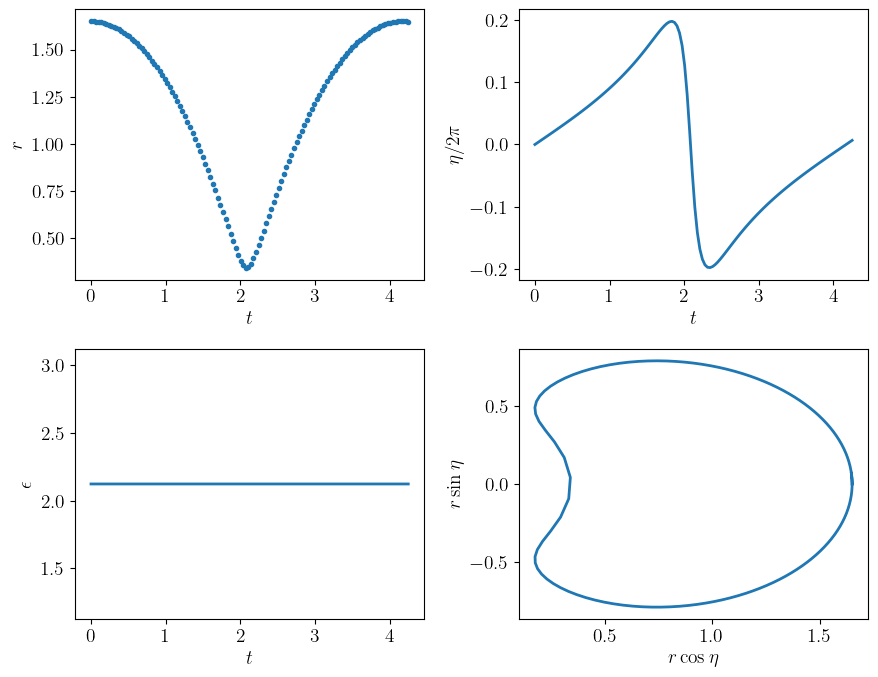

In [32]:
fig, axs = plt.subplots(2,2)
axs[0,0].plot(t[:fstep],z[0,:fstep],'.') # plot individual points for radius signal
axs[0,0].set_xlabel(r'$t$')
axs[0,0].set_ylabel(r'$r$')
axs[0,1].plot(t[:fstep],z[1,:fstep]/(2*math.pi)) # phase signal in unit of 2\pi
axs[0,1].set_xlabel(r'$t$')
axs[0,1].set_ylabel(r'$\eta/2\pi$')
axs[1,0].plot(t[:fstep],Energy[:fstep]) # energy signal
axs[1,0].set_ylim([np.max(Energy)-1,np.max(Energy)+1])
axs[1,0].set_xlabel(r'$t$')
axs[1,0].set_ylabel(r'$\epsilon$')
axs[1,1].plot(z[0,:fstep]*np.cos(z[1,:fstep]),z[0,:fstep]*np.sin(z[1,:fstep])) # energy orbit on bowl
axs[1,1].set_xlabel(r'$r\cos\eta$')
axs[1,1].set_ylabel(r'$r\sin\eta$')
fig.tight_layout();

In [33]:
oscs = pd.DataFrame(z.T,columns=['r','eta'])
oscs['rescaled_r'] = 10.5*oscs['r'] # artificially rescaling the radius signal for visualization purposes
rvals = oscs['rescaled_r'].values
evals = oscs['eta'].values

print('dataframe head: \n')
print(oscs.head())
print('\n')
print('min r: ', oscs['rescaled_r'].min())
print('max r: ', oscs['rescaled_r'].max())

dataframe head: 

          r       eta  rescaled_r
0  1.650000  0.000000   17.325000
1  1.649644  0.017440   17.321265
2  1.648577  0.034892   17.310057
3  1.646797  0.052366   17.291374
4  1.644306  0.069873   17.265208


min r:  3.5876851319880907
max r:  17.325


In [34]:
print(evals[122:124]) # 1 oscillation occurs just before 123 time steps

[-0.01058343  0.00685583]


In [35]:
df = pd.concat([generate_df(r,e) for r,e in zip(rvals,evals)],keys=range(len(rvals)),axis=1)

df.index = df.index.set_names('spins')
df.columns = df.columns.set_names('times',level=0)

df

times   0                                     1                      ...  125  \
          x     y    z      u      v      w     x     y    z      u  ...    z   
spins                                                                ...        
0     -25.0 -25.0  0.0 -0.000 -0.000  1.000 -25.0 -25.0  0.0 -0.000  ...  0.0   
1     -25.0 -22.0  0.0 -0.001 -0.000  1.000 -25.0 -22.0  0.0 -0.001  ...  0.0   
2     -25.0 -19.0  0.0 -0.001 -0.001  1.000 -25.0 -19.0  0.0 -0.001  ...  0.0   
3     -25.0 -16.0  0.0 -0.003 -0.002  1.000 -25.0 -16.0  0.0 -0.003  ...  0.0   
4     -25.0 -13.0  0.0 -0.008 -0.004  1.000 -25.0 -13.0  0.0 -0.008  ...  0.0   
...     ...   ...  ...    ...    ...    ...   ...   ...  ...    ...  ...  ...   
284    23.0  11.0  0.0  0.030  0.015  0.999  23.0  11.0  0.0  0.030  ...  0.0   
285    23.0  14.0  0.0  0.014  0.009  1.000  23.0  14.0  0.0  0.014  ...  0.0   
286    23.0  17.0  0.0  0.006  0.004  1.000  23.0  17.0  0.0  0.006  ...  0.0   
287    23.0  20.0  0.0  0.002  0.002  1.000  23.0  20.0  0.0  0.002  ...  0.0   
288    23.0  23.0  0.0  0.001  0.001  1.000  23.0  23.0  0.0  0.001  ...  0.0   

times                        126                                  
           u      v      w     x     y    z      u      v      w  
spins                                                             
0     -0.000 -0.000  1.000 -25.0 -25.0  0.0 -0.000 -0.000  1.000  
1     -0.000 -0.000  1.000 -25.0 -22.0  0.0 -0.000 -0.000  1.000  
2     -0.001 -0.001  1.000 -25.0 -19.0  0.0 -0.001 -0.001  1.000  
3     -0.003 -0.002  1.000 -25.0 -16.0  0.0 -0.003 -0.002  1.000  
4     -0.008 -0.004  1.000 -25.0 -13.0  0.0 -0.007 -0.004  1.000  
...      ...    ...    ...   ...   ...  ...    ...    ...    ...  
284    0.029  0.016  0.999  23.0  11.0  0.0  0.029  0.016  0.999  
285    0.014  0.009  1.000  23.0  14.0  0.0  0.013  0.009  1.000  
286    0.005  0.004  1.000  23.0  17.0  0.0  0.005  0.004  1.000  
287    0.002  0.002  1.000  23.0  20.0  0.0  0.002  0.002  1.000  
288    0.001  0.001  1.000  23.0  23.0  0.0  0.001  0.001  1.000  

[289 rows x 762 columns]

Plot initial configuration

In [36]:
layout = go.Layout(
    width=800,
    height=600,
    autosize=False,
    scene=dict( 
        camera = dict(eye=dict(x=0.64,y=0.99,z=0.89)), # adjust norm of `eye` to zoom
        xaxis=dict(range=[-26,26],showbackground=False,visible=False),
        yaxis=dict(range=[-26,26],showbackground=False,visible=False),
        zaxis=dict(range=[-26,26],showbackground=False,visible=False),

    )
)

conedata = [
    go.Cone(**pd.DataFrame(df[0].loc[n]).T.to_dict(orient='list'),
                   anchor='cm',
                   sizemode='scaled',
                   sizeref=2.5,
                   showscale=False)
    for n in range(len(df))
]

fig = go.Figure(data=conedata, layout=layout)
fig.update_layout(
title='<b>Oscillatory breathing</b>',
title_x=0.5,
title_y=0.85,
title_font_size=28
)
fig.show()

In [37]:
if not(os.path.exists('pngs-oscs/006.png')):
    print('test')

In [38]:
# Exporting a single oscillation to png files in a new subdirectory

if not(os.path.exists('pngs-oscs')):
    os.mkdir('pngs-oscs')

# make layout nice and large before cropping
layout = go.Layout(
    width=1250,
    height=758,
    autosize=False,
    scene=dict( 
        camera = dict(eye=dict(x=0.64,y=0.99,z=0.89)), # adjust norm of `eye` to zoom
        xaxis=dict(range=[-26,26],showbackground=False,visible=False),
        yaxis=dict(range=[-26,26],showbackground=False,visible=False),
        zaxis=dict(range=[-26,26],showbackground=False,visible=False),

    )
)
    
for i in range(124):
    if not(os.path.exists("pngs-oscs/{0:03d}.png".format(i))):
        conedata = [
            go.Cone(**pd.DataFrame(df[i].loc[n]).T.to_dict(orient='list'),
                           anchor='cm',
                           sizemode='scaled',
                           sizeref=2.5,
                           showscale=False)
            for n in range(len(df))
        ]
        fig = go.Figure(data=conedata, layout=layout)
        fig.update_layout(
        title='<b>Oscillatory breathing</b>',
        title_x=0.5,
        title_y=0.85,
        title_font_size=28
        )
        fig.write_image("pngs-oscs/{0:03d}.png".format(i)) # pip install -U kaleido

In [39]:
# cropping the png files

paths = glob.glob("pngs-oscs/*.png")

if not(os.path.exists('pngs-oscs/cropped')):
    os.mkdir('pngs-oscs/cropped')
    
for path in paths:
    dest_path = os.path.join(path.split('/')[0],'cropped',path.split('/')[1])
    if not(os.path.exists(dest_path)):
        crop_image(path,dest_path) 

In [40]:
# !ffmpeg -framerate 10 -i pngs-oscs/cropped/%03d.png -f mp4 -vcodec libx264 -vf scale=1280:-2 -pix_fmt yuv420p oscs.mp4

In [41]:
Video("oscs.mp4", width=700)

## 5: Example figure from our publication

For reference, in this section I include the matplotlib code I used for creating the line plots in Figure 4(a) of our [paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.054430).

In [42]:
# data in 'effective_breathing_data.csv' was created similarly as in section 4 above.
!head -n 3 effective_breathing_data.csv

# time, r, eta, energy, r_damped, eta_damped, energy_damped 
0.0, 6.4, 0.0, 3.2781250000000006, 6.4, 0.0, 3.2781250000000006
0.01, 6.399998173703034, 0.0007169064571036894, 3.2781250000000006, 6.399976108462477, 0.0007168420114624561, 3.278114236568656


/var/folders/g7/gdhc8lyj3sjbb1p19f8tqmj00000gn/T/ipykernel_18387/3164082369.py:105: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



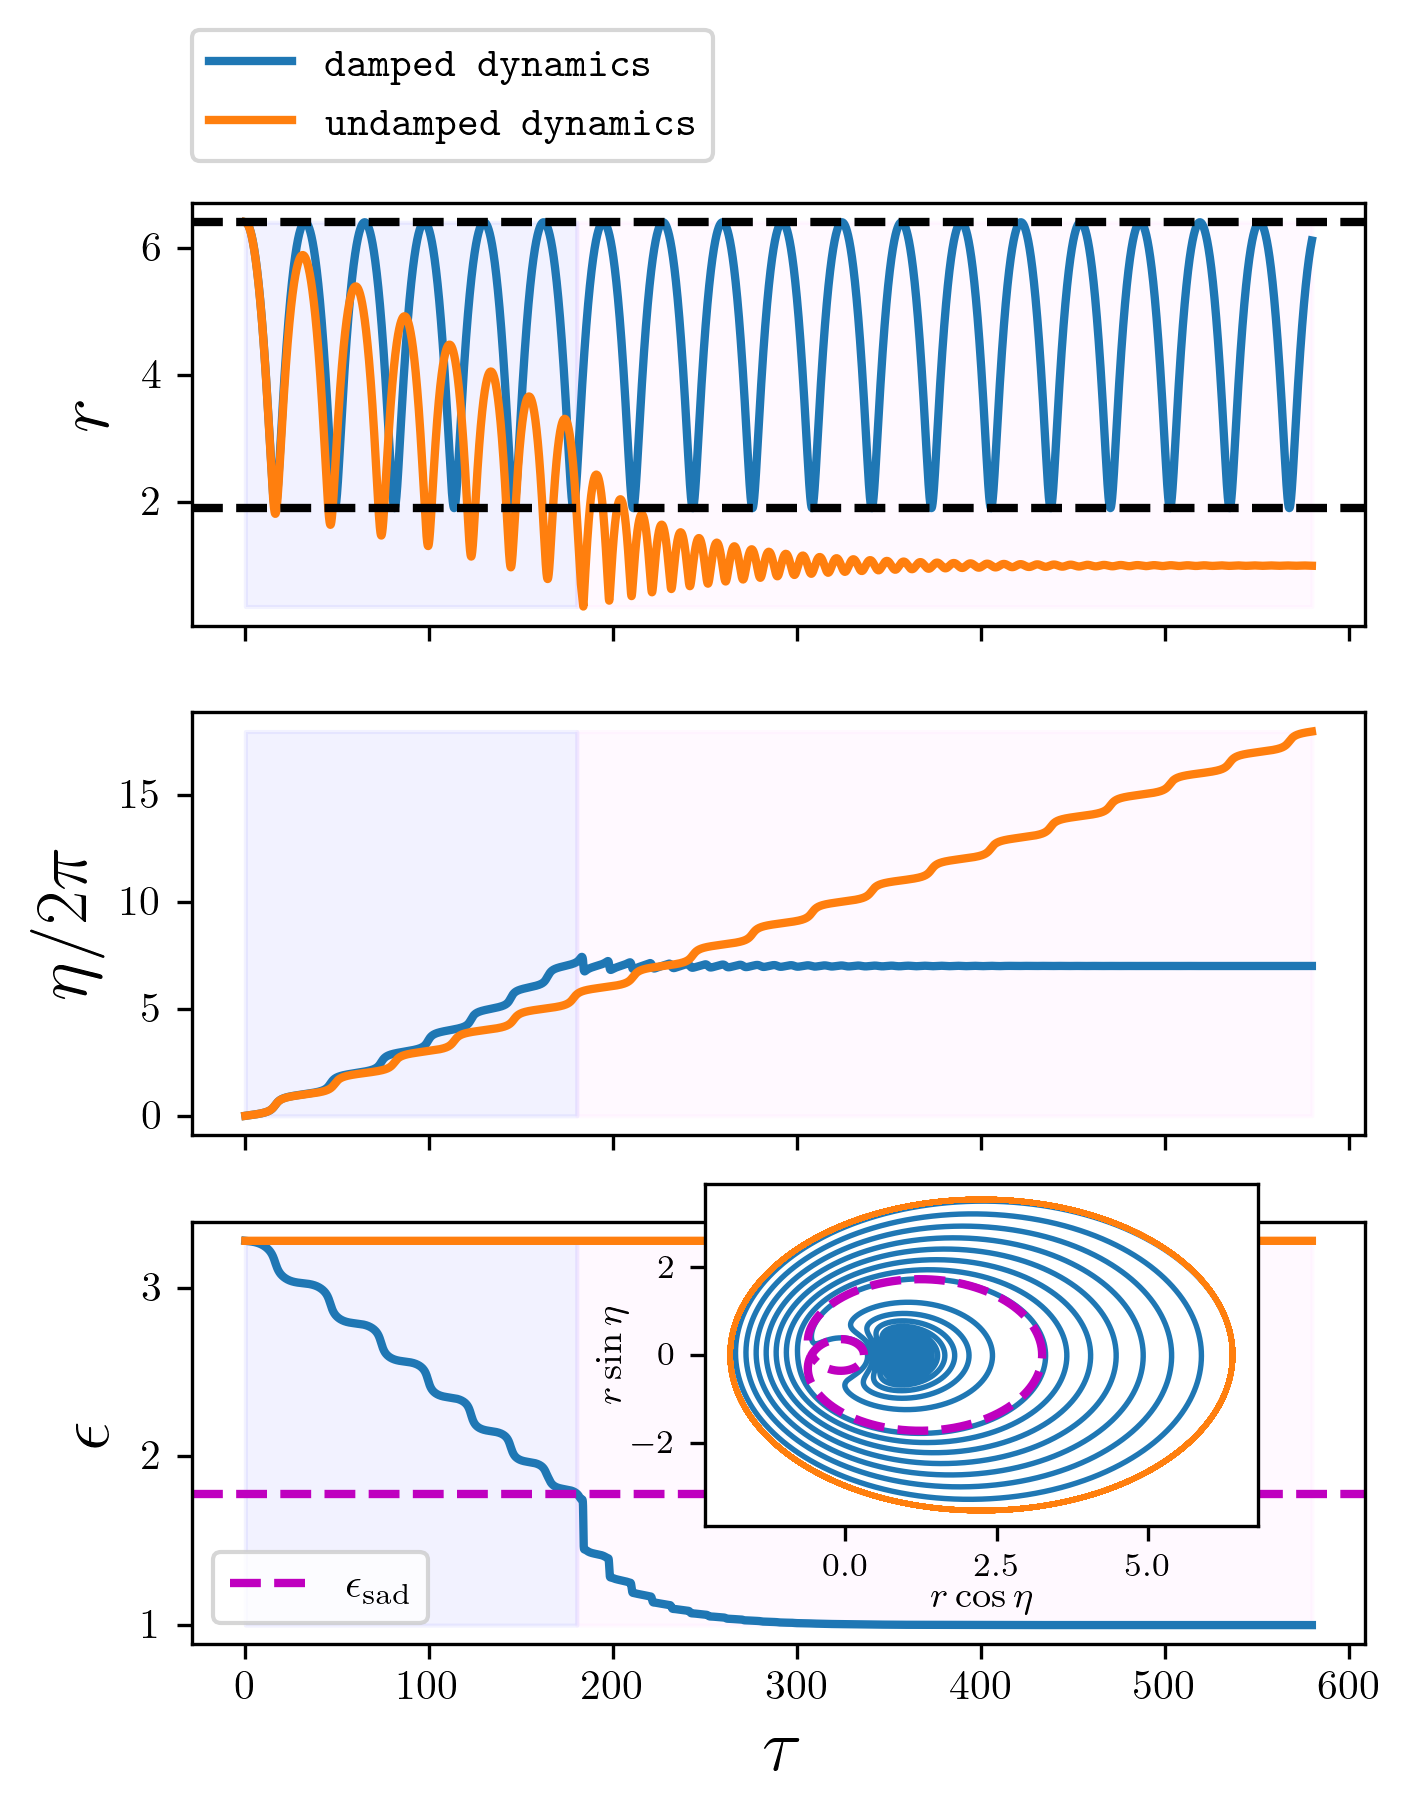

In [43]:
# loading the data into 1D np.ndarrays (data provided in GitHub repo)
data = np.loadtxt('effective_breathing_data.csv',delimiter=',')
t = data[:,0]
r, eta, energy = (data[:,1],data[:,2],data[:,3]) 
r_damped, eta_damped, energy_damped = (data[:,4],data[:,5],data[:,6])

# Some pre-processing of the data
B = 0.52 # material parameter, plays the role of g elsewhere in this demo
Esad = math.sqrt((1+np.abs(B))/(1-np.abs(B))) # saddle energy calculation

for n,i in enumerate(energy_damped):
    if i<Esad:
        transition_point = n # locate transition point from bowl to basin
        break
bowl_times = t[:transition_point]
basin_times = t[transition_point:]

# Setting up matplotlib parameters
SMALLEST_SIZE=10
SMALL_SIZE = 16
BIGGER_SIZE = 18
matplotlib.rc('text',usetex = True)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALLEST_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALLEST_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLEST_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
matplotlib.rcParams['figure.dpi'] = 300

# Initializing the figure
fig, ax = plt.subplots(3,sharex=True,figsize=[4.98,6.34])

# Top panel: Radius versus time line plots
ax[0].plot(t,r,label='damped dynamics')
ax[0].plot(t,r_damped,label='undamped dynamics')
ax[0].axhline(y=np.min(r), color='k', linestyle='--')
ax[0].axhline(y=np.max(r), color='k', linestyle='--')
# shade the background to show location on the energy landscape
ax[0].fill_between(bowl_times,np.min(r_damped),np.max(r),
    color='blue',alpha=0.05)
ax[0].fill_between(basin_times,np.min(r_damped),np.max(r),
    color='magenta',alpha=0.025)
# create legend at top left of figure
ax[0].legend(bbox_to_anchor=(0.0, 1.1), loc='lower left', borderaxespad=0.)
ax[0].set_ylabel(r'$r$')
          
# Middle panel: skyrmion phase in units of 2\pi versus time 
ax[1].plot(t,eta_damped/(2*math.pi))
ax[1].plot(t,eta/(2*math.pi))
ax[1].fill_between(bowl_times,np.min(eta_damped)/(2*math.pi),
    np.max(eta)/(2*math.pi),color='blue',alpha=0.05)
ax[1].fill_between(basin_times,np.min(eta)/(2*math.pi),
    np.max(eta)/(2*math.pi),color='magenta',alpha=0.025)
ax[1].set_ylabel(r'$\eta/2\pi$')

# Bottom panel: energy versus time plots
ax[2].plot(t,energy_damped)
ax[2].plot(t,energy)
ax[2].fill_between(bowl_times,np.min(energy_damped),np.max(energy),
    color='blue',alpha=0.05)
ax[2].fill_between(basin_times,np.min(energy_damped),np.max(energy_damped),
    color='magenta',alpha=0.025)

if init_energy > Esad:
    # create horizontal magenta line for saddle energy
    ax[2].axhline(y=Esad, color='m',linestyle='--',label=r'$\epsilon_{\mathrm{sad}}$')
    ax[2].legend(loc='lower left')
ax[2].set_xlabel(r'$\tau$')
ax[2].set_ylabel(r'$\epsilon$')

# Inset (bottom): 
# Trajectories on a plane polar parametric plot
# for comparison with the energy landscape figures
ax1 = plt.axes([0.50,0.175,0.37,0.18])
ax1.plot(r_damped*np.cos(eta_damped),r_damped*np.sin(eta_damped),lw=1.3)
ax1.plot(r*np.cos(eta),r*np.sin(eta),lw=1.3)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
ax1.set_xlabel(r'$r\cos\eta$',fontsize='9')
ax1.set_ylabel(r'$r\sin\eta$',fontsize='9')
ax1.xaxis.labelpad = 0.5
ax1.yaxis.labelpad = 0.2

def trajectory(E,B,eta):
    """
    Equations for the trajectories on the
    plane polar (r\cos\eta, r\sin\eta) parametric plot.
    """
    Btheta = (1-B*np.cos(eta))/(1-np.abs(B))
    r1 = (E/Btheta)*(1+np.sqrt(1-(Btheta/(E**2))))
    r2 = (E/Btheta)*(1-np.sqrt(1-(Btheta/(E**2))))
    return r1,r2

theta  = np.linspace(0.0,2.0*math.pi,1000)
t1, t2 = trajectory(Esad,0.52,theta) # energy separatrix

ax1.plot(t2*np.cos(theta),t2*np.sin(theta), 'm--')
ax1.plot(t1*np.cos(theta),t1*np.sin(theta), 'm--')

today = str(date.today())+'.png'
fig.tight_layout()
#plt.savefig(today,bbox_inches='tight')
#plt.show()
#plt.close()